<a href="https://colab.research.google.com/github/zhanglab-aim/ucla-automl-workshop/blob/main/UCLA_AutoML_workshop_Day0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 0. Data Simulation

- use `simdna` python package to generate data
- build a simple CNN to model it

Reference:
http://compbio.mit.edu/encode-motifs/


## Installation

In [1]:
%pip install -q simdna==0.4.3.2 amber-automl==0.1.5

In [2]:
#!git clone https://github.com/zj-zhang/AMBER.git
#!cd AMBER; python setup.py develop

In [3]:
!amber-cli config -b tensorflow_2
!amber-cli -v

Setting the default backend to "tensorflow_2".

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

 █████╗ ███╗   ███╗██████╗ ███████╗██████╗ 
██╔══██╗████╗ ████║██╔══██╗██╔════╝██╔══██╗
███████║██╔████╔██║██████╔╝█████╗  ██████╔╝
██╔══██║██║╚██╔╝██║██╔══██╗██╔══╝  ██╔══██╗
██║  ██║██║ ╚═╝ ██║██████╔╝███████╗██║  ██║
╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚══════╝╚═╝  ╚═╝

Automated Modeling of Biological Evidence-based Research
Version 0.1.5


## Simulate data

In [4]:
!densityMotifSimulation.py --prefix targets --motifNames CTCF_known1 --max-motifs 2 --min-motifs 1 --mean-motifs 1 --seqLength 200 --numSeqs 2500 --seed 777
!emptyBackground.py --prefix empty_bg --seqLength 200 --numSeqs 2500

In [5]:
import amber
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from amber.utils import data_parser
%matplotlib inline

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


amber.utils.data_parser failed to import pysam; sequence utility will be limited


In [6]:
x, y = data_parser.get_data_from_simdata(
    positive_file="DensityEmbedding_prefix-targets_motifs-CTCF_known1_min-1_max-2_mean-1_zeroProb-0_seqLength-200_numSeqs-2500.simdata",
    negative_file="EmptyBackground_prefix-empty_bg_seqLength-200_numSeqs-2500.simdata",
    targets=['CTCF']
)

In [7]:
np.savez('genomic_data.npz', x=x, y=y)

## A simple CNN model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same', input_shape=(200,4), name='conv_1'),
    tf.keras.layers.MaxPool1D(pool_size=4, padding='same', name='maxpool_1'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=1, padding='same', name='conv_2'),
    tf.keras.layers.GlobalAveragePooling1D(name='gap'),
    tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC(curve='ROC', name='auroc')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 200, 32)           928       
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 50, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 50, 128)           28800     
                                                                 
 gap (GlobalAveragePooling1D  (None, 128)              0         
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
____________________________________________________

In [9]:
hist = model.fit(x, y, validation_split=0.1, batch_size=64, epochs=20, verbose=True)

Epoch 1/20
71/71 [==============================] - 5s 30ms/step - loss: 0.6726 - acc: 0.5787 - auroc: 0.6122 - val_loss: 0.6111 - val_acc: 0.6840 - val_auroc: 0.7878
Epoch 2/20
71/71 [==============================] - 2s 25ms/step - loss: 0.5954 - acc: 0.6822 - auroc: 0.7446 - val_loss: 0.5417 - val_acc: 0.7200 - val_auroc: 0.8086
Epoch 3/20
71/71 [==============================] - 2s 25ms/step - loss: 0.5683 - acc: 0.7020 - auroc: 0.7734 - val_loss: 0.5271 - val_acc: 0.7300 - val_auroc: 0.8249
Epoch 4/20
71/71 [==============================] - 2s 25ms/step - loss: 0.5393 - acc: 0.7256 - auroc: 0.8009 - val_loss: 0.5891 - val_acc: 0.6720 - val_auroc: 0.8424
Epoch 5/20
71/71 [==============================] - 2s 25ms/step - loss: 0.5120 - acc: 0.7422 - auroc: 0.8245 - val_loss: 0.4918 - val_acc: 0.7420 - val_auroc: 0.8570
Epoch 6/20
71/71 [==============================] - 2s 24ms/step - loss: 0.4962 - acc: 0.7578 - auroc: 0.8373 - val_loss: 0.4651 - val_acc: 0.7820 - val_auroc: 0.861

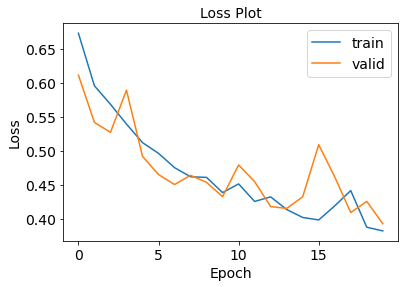

In [10]:
# check the loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

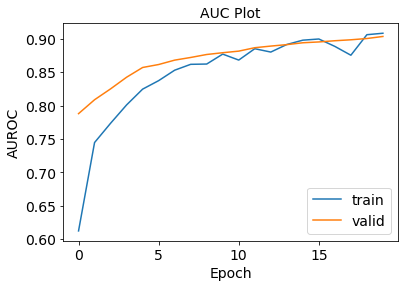

In [11]:
# check the auc plot
plt.plot(hist.history['auroc'])
plt.plot(hist.history['val_auroc'])
plt.title('AUC Plot')
plt.ylabel('AUROC')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()